# Simple RAG Chain example with In Memory Vector Database and local .pdf loader

### Set .env variables

In [15]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("LANGCHAIN_API_KEY")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


### Import Dependencies

In [16]:
import contextlib
from typing import TypedDict, Annotated, Literal, List, Optional, Any
from enum import Enum

from langchain_core.messages import BaseMessage, AIMessage
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.graph import StateGraph, END, add_messages

### Embeddings declaration

In [17]:
# Simplified versions of your module code
def get_openai_embeddings(
    model: str = "text-embedding-ada-002",
    dimensions: Optional[int] = None,
    **kwargs: Any
) -> OpenAIEmbeddings:
    return OpenAIEmbeddings(model=model, dimensions=dimensions, **kwargs)

### Loader declaration

In [18]:
def load_pdf(
    file_path: str,
    chunk_size: int = 1000,
    chunk_overlap: int = 200,
    silent: bool = True
) -> List[Document]:
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"PDF file not found: {file_path}")
    
    loader = PyPDFLoader(file_path)
    
    if silent:
        with open(os.devnull, "w") as f, contextlib.redirect_stderr(f):
            docs = loader.load()
    else:
        docs = loader.load()
    
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, 
        chunk_overlap=chunk_overlap
    )
    
    return text_splitter.split_documents(docs)

### Vectorstore declaration

In [19]:
def create_vectorstore(
    documents: List[Document],
    embedding_model: Optional[object] = None
):
    if embedding_model is None:
        raise ValueError("embedding_model must be provided to create a vectorstore")
        
    return InMemoryVectorStore.from_documents(
        documents=documents,
        embedding=embedding_model
    )

### Graph logics

In [20]:
# Define the state type for our graph
class GraphState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    documents: list[Document]
    current_answer: str

def create_rag_graph(pdf_path: str, model_name: str = "gpt-4", temperature: float = 0.4):
    """
    Create a RAG workflow graph for querying PDF documents
    """
    # Initialize LLM
    llm = ChatOpenAI(model_name=model_name, temperature=temperature)
    
    try:
        # Load and split the PDF
        print(f"Loading PDF from {pdf_path}...")
        splits = load_pdf(
            file_path=pdf_path,
            chunk_size=1000,
            chunk_overlap=200
        )
        print(f"Loaded {len(splits)} document splits")
        
        # Create vector store and retriever
        print("Creating vectorstore...")
        embedding_model = get_openai_embeddings()
        vectorstore = create_vectorstore(
            documents=splits,
            embedding_model=embedding_model
        )
        retriever = vectorstore.as_retriever(
            search_type="similarity",
            search_kwargs={"k": 4}
        )

    except Exception as e:
        print(f"Error during initialization: {str(e)}")
        raise

    # Define the prompt template
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful assistant that answers questions based on the provided context."),
        ("human", "Context:\n\n{context}\n\nQuestion: {question}")
    ])

    # Define node functions
    def retrieve_documents(state: GraphState):
        """Retrieve relevant documents based on the query"""
        question = state["messages"][-1].content
        documents = retriever.invoke(question)
        return {"documents": documents}

    def generate_answer(state: GraphState):
        """Generate answer using retrieved documents"""
        question = state["messages"][-1].content
        documents = state["documents"]
        context = "\n\n".join([doc.page_content for doc in documents])
        
        chain = prompt | llm | StrOutputParser()
        answer = chain.invoke({
            "context": context,
            "question": question
        })
        
        return {"current_answer": answer}

    def finalize_response(state: GraphState):
        """Create the final response"""
        return {"messages": [AIMessage(content=state["current_answer"])]}

    # Create the graph
    workflow = StateGraph(GraphState)

    # Add nodes
    workflow.add_node("retrieve", retrieve_documents)
    workflow.add_node("generate", generate_answer)
    workflow.add_node("finalize", finalize_response)

    # Add edges
    workflow.set_entry_point("retrieve")
    workflow.add_edge("retrieve", "generate")
    workflow.add_edge("generate", "finalize")
    workflow.add_edge("finalize", END)

    return workflow.compile()

### Create graph with RAG on file

In [21]:
pdf_path = "../data/raw/research.pdf"
print("Creating RAG graph...")
graph = create_rag_graph(pdf_path)

Creating RAG graph...
Loading PDF from ../data/raw/research.pdf...
Loaded 91 document splits
Creating vectorstore...


### Visualize Graph


Graph Structure:


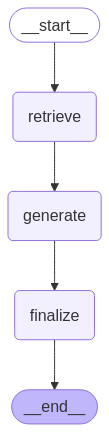

In [22]:
# Print the graph structure
print("\nGraph Structure:")
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

### Invoke Graph

In [23]:
# Test query
print("\nTesting with a sample query...")
response = graph.invoke({
    "messages": [AIMessage(content="Explain the main concept")]
})
print("\nAnswer:")
print(response["messages"][-1].content)


Testing with a sample query...

Answer:
The main concept of this context revolves around identifying key factors that influence the adoption and use of cryptocurrency (CUS). The research questions aim to identify the key drivers that can increase or decrease the use of cryptocurrency, the personality type that has the most CUS, the gender more likely to take risks in cryptocurrency, the main key driver affecting CUS, the possibility of regulating cryptocurrency adoption with positive key drivers, and the role of education and knowledge in the cryptocurrency adoption process. The context also discusses the role of personality traits, knowledge, and community in cryptocurrency usage.
